In [1]:
#!/usr/bin/env python
# coding: utf-8

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from LogGabor import LogGabor
from what_where.main import init, MNIST
from what_where.where import RetinaFill, WhereShift, RetinaBackground, RetinaMask
from POLO.PYramid2 import cropped_pyramid, local_filter, get_K, log_gabor_transform
from POLO.PYramid2 import inverse_pyramid, get_K_inv, inverse_gabor
from utils import view_data
from typing import List, Tuple

import pickle

width = {'in': 32, 'out': 64, 'ext': 128}

n_levels = {'in': 3, 'out': 3, 'ext': 3} 

base_levels = 2

n_color = {'in': 3, 'out': 3, 'ext': 3}

color = True

color_mode= 'rgb' #'lab' # 'hsv' #True

r_min = {'in': width['in'] / 4, 'out': width['out'] / 4, 'ext': width['ext'] / 4}

r_max = {'in': width['in'] / 2, 'out': width['out'] / 2, 'ext': width['ext'] / 2}

n_sublevel = n_eccentricity = {'in': 2, 'out': 4, 'ext': 8}

n_azimuth = {'in': 16, 'out': 32, 'ext': 64}

n_theta = {'in': 8, 'out': 8, 'ext': 8}

n_phase = {'in': 1, 'out': 1, 'ext': 1}

do_mask = False

gauss = False



lg={}
for k in ['in', 'out', 'ext']:
    pe = {'N_X': width[k], 'N_Y': width[k], 'do_mask': do_mask, 'base_levels':
              base_levels, 'n_theta': 0, 'B_sf': np.inf, 'B_theta': np.inf ,
          'use_cache': True, 'figpath': 'results', 'edgefigpath':
              'results/edges', 'matpath': 'cache_dir', 'edgematpath':
              'cache_dir/edges', 'datapath': 'database/', 'ext': '.pdf', 'figsize':
              14.0, 'formats': ['pdf', 'png', 'jpg'], 'dpi': 450, 'verbose': 0}   

    lg[k] = LogGabor(pe)



K = {}
for k in ['in', 'out', 'ext']:
    K[k] = get_K(width=width[k],
          n_sublevel = n_sublevel[k], 
          n_azimuth = n_azimuth[k], 
          n_theta = n_theta[k],
          n_phase = n_phase[k], 
          r_min = r_min[k], 
          r_max = r_max[k], 
          log_density_ratio = 2, 
          verbose=True,
          lg=lg[k])




args = init(filename='2020-07-01')
args


# In[7]:


class DualCroppedPyramid(object):
    def __init__(self, width, 
                 base_levels, 
                 color=color, 
                 do_mask=do_mask, 
                 verbose=False, 
                 n_levels=None, 
                 color_mode='rgb'):
        self.width = width
        self.base_levels = base_levels
        self.color = color
        self.do_mask = do_mask
        self.verbose = verbose
        self.n_levels = n_levels
        self.color_mode = color_mode

    def __call__(self, img):
        img_crop = {}
        for k in ['in', 'out', 'ext']:
            img_crop_part, level_size = cropped_pyramid(img.unsqueeze(0), 
                                               width=self.width[k], 
                                               base_levels=self.base_levels,
                                               color=self.color, 
                                               do_mask=self.do_mask, 
                                               verbose=self.verbose,
                                               squeeze=True,
                                               gauss=gauss,
                                               n_levels=self.n_levels[k],
                                               color_mode=self.color_mode)
            #print(img_crop_part.shape)
            img_crop[k] = img_crop_part[:self.n_levels[k]-1,...]
        return img, img_crop   




class DualLogGaborTransform(object):
    def __init__(self, K=K, color=color, verbose=False):
        self.K = K
        self.color = color
        self.verbose = verbose

    def __call__(self, cropped_pyr):
        img = cropped_pyr[0]
        img_crop = cropped_pyr[1]
        log_gabor_coeffs = {}
        for k in ['in', 'out', 'ext']:
            log_gabor_coeffs[k] = log_gabor_transform(img_crop[k].unsqueeze(1), K[k], color=self.color).squeeze(1)
        
        return img, log_gabor_coeffs




class DualLogGaborReshape(object):
    def __init__(self, n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color, verbose=False):
        self.n_levels = n_levels
        self.n_color = n_color
        self.n_eccentricity = n_eccentricity 
        self.n_azimuth = n_azimuth 
        self.n_theta = n_theta
        self.n_phase = n_phase  
        self.color = color
        self.verbose = verbose

    def __call__(self, log_gabor_transform):
        img = log_gabor_transform[0]
        log_gabor_coeffs = log_gabor_transform[1]
        for k in ['in', 'out', 'ext']:
            # n_batch, n_levels, n_color, n_sublevel, n_azimuth, n_theta, n_phase
            # x      , 0       , 1      , 2         , 3        , 4      , 5
            # 
            #print(log_gabor_coeffs[k].shape)
            log_gabor_coeffs[k] = log_gabor_coeffs[k].permute(1, 4, 5, 0, 2, 3).contiguous()
            log_gabor_coeffs[k] = log_gabor_coeffs[k].view(self.n_color[k]*self.n_theta[k]*self.n_phase[k], 
                                                     (self.n_levels[k]-1) * self.n_eccentricity[k], 
                                                     self.n_azimuth[k])
 
        return img, log_gabor_coeffs



v_mean = np.array([0.485, 0.456, 0.406])
v_std = np.array([0.229, 0.224, 0.225])
transforms_norm = transforms.Normalize(mean=v_mean, std=v_std) # to normalize colors on the imagenet dataset

image_size = 256

polo_transform =  transforms.Compose([
            transforms.Resize((int(image_size), int(image_size))),
            #transforms.AutoAugment(), # https://pytorch.org/vision/master/transforms.html#torchvision.transforms.AutoAugment
            transforms.ToTensor(),      # Convert the image to pyTorch Tensor data type.
            transforms_norm, 
            DualCroppedPyramid(width=width, 
                  base_levels=base_levels,
                  color=color,
                  n_levels=n_levels),
            DualLogGaborTransform(K=K, color=color),
            DualLogGaborReshape(n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color),
        ])

# In[17]:


#image_path = "/envau/work/brainets/dauce.e/data/animal/"
#image_path = "/media/manu/Seagate Expansion Drive/Data/animal/"
image_path = "/home/INT/dauce.e/data/Imagenet_full/"
#image_path = "/run/user/1001/gvfs/sftp:host=bag-008-de03/envau/work/brainets/dauce.e/data/animal/"
#image_path = "../data/animal/"

image_dataset = { 'train' : datasets.ImageFolder(
                            image_path+'train', 
                            transform=polo_transform
                        ),
                  'test' : datasets.ImageFolder(
                            image_path+'val', 
                            transform=polo_transform
                        )
                }

# In[18]:


dataset_size = {'train' : len(image_dataset['train']),
                'test' : len(image_dataset['test'])}

dataset_size['train'], dataset_size['test']


# In[19]:


args.batch_size = 50
num_workers = 1

dataloader = { 'train' : torch.utils.data.DataLoader(
                            image_dataset['train'], batch_size=args.batch_size,
                            shuffle=True, 
                            num_workers=num_workers,
                        ),
               'test' : torch.utils.data.DataLoader(
                            image_dataset['test'], batch_size=args.batch_size,
                            shuffle=True, 
                            num_workers=num_workers,
                        )
             }



# # Creating an Attention Transformer model with log-polar entry (POLO-STN)

# In[28]:


transform_in =  transforms.Compose([
            DualCroppedPyramid(width=width, 
                  base_levels=base_levels,
                  color=color,
                  n_levels=n_levels),
            DualLogGaborTransform(K=K, color=color),
            DualLogGaborReshape(n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color),
        ])


# In[29]:


def negentropy_loss(model, z):
    z_mean = torch.mean(z, dim=0) + 1e-6
    z_std = torch.std(z, dim=0)
    if model.do_stn or args.radius > 0:
        p = torch.distributions.Normal(torch.ones_like(z)*z_mean, torch.ones_like(z) * z_std)
    else:
        p = torch.distributions.Normal(torch.zeros_like(z), 1e-6 * torch.ones_like(z))

    #p = torch.distributions.Normal(torch.ones_like(z)*z_mean, torch.ones_like(z) * z_std)
    return p.log_prob(z).sum()

def kl_divergence(model, z):
    # --------------------------
    # Monte carlo KL divergence
    # --------------------------
    # 1. define the first two probabilities (in this case Normal for both)
    z_dims = z.size()
    if args.radius > 0:
        #p = torch.distributions.Normal(torch.zeros_like(z), args.radius * torch.ones_like(z))
        p = torch.distributions.MultivariateNormal(torch.zeros_like(z), 
                                                   args.radius * torch.einsum('i,jk->ijk',torch.ones(z_dims[0]), torch.eye(2)))
    else:
        p = torch.distributions.Normal(torch.zeros_like(z), 1e-6 * torch.ones_like(z))


    # 2. get the probabilities from the equation
    #log_qzx = model.q.log_prob(z)
    log_pz = p.log_prob(z)

    z_mean = torch.mean(z, dim=0)
    z_std = torch.std(z, dim=0) + 1e-6
    #print(z)
    #print(torch.cov(z.T))
    #print(torch.eye(2))
    z_cov = torch.cov(z.T) + 1e-6 * torch.eye(2).to(device)
    #print(z_std)
    #q = torch.distributions.MultivariateNormal(torch.ones_like(z)*z_mean, torch.ones_like(z) * z_std)
    q = torch.distributions.MultivariateNormal(torch.ones_like(z)*z_mean, torch.ones(z_dims[0], 2, 2).to(device) * z_cov)
    log_qzx = q.log_prob(z)

    # kl
    kl = (log_qzx - log_pz)
    
    # sum over last dim to go from single dim distribution to multi-dim
    kl = kl.sum()
    return kl

# In[30]:
class Polo_AttentionTransNet(nn.Module):
    
    def __init__(self, do_stn=True, do_what=False, deterministic=False, LAMBDA=.1):
        super(Polo_AttentionTransNet, self).__init__()
        
        self.do_stn = do_stn
        self.do_what = do_what
        self.deterministic = deterministic
        
        self.LAMBDA = LAMBDA

        ##  The what pathway
        self.wloc0 = nn.Conv2d(n_color['ext'] * n_theta['ext'] * n_phase['ext'], 
                              50, 3, padding=1)
        self.wloc1a = nn.Conv2d(50, 100, 3, padding=1)
        self.wloc1b = nn.Conv2d(n_color['out'] * n_theta['out'] * n_phase['out'], 
                              100, 3, padding=1)
        self.wloc2a = nn.Conv2d(100, 200, 3, padding=1)
        self.wloc2b = nn.Conv2d(100, 200, 3, padding=1)
        self.wloc2c = nn.Conv2d(n_color['in'] * n_theta['in'] * n_phase['in'], 
                               200, 3, padding=1)
        self.wloc3 = nn.Conv2d(200, 500, 3, padding=1)
        self.wloc4 = nn.Conv2d(500, 1000, 3, padding=1)
        self.wloc5_short = nn.Linear(1000 * (((n_levels['in']-1) * n_eccentricity['in'] * 3) // 8 * n_azimuth['in'] // 8), 1000, bias=False)
        self.wloc5 = nn.Linear(1000 * (((n_levels['in']-1) * n_eccentricity['in'] * 3) // 8 * n_azimuth['in'] // 8), 1000)
        self.wloc6 = nn.Linear(1000, 1000, bias=False)

        #self.wloc4.weight.data.zero_()
        #self.wloc4.bias.data.zero_()

                
        ##  The where pathway        
        self.loc_ext_1 = nn.Conv2d(n_color['ext'] * n_theta['ext'] * n_phase['ext'], 
                              128, 3, padding=1, stride=1)
        self.loc_ext_2 = nn.Conv2d(32, 128, 5, padding=2, stride=1)
        self.loc_ext_3 = nn.Conv2d(32, 128, 7, padding=3, stride=1)

        self.loc_out_1 = nn.Conv2d(n_color['out'] * n_theta['out'] * n_phase['out'], 
                              128, 3, padding=1, stride=1)
        self.loc_out_2 = nn.Conv2d(32, 128, 5, padding=2,stride=1)

        self.loc_in_1 = nn.Conv2d(n_color['in'] * n_theta['in'] * n_phase['in'], 
                              128, 3, padding=1, stride=1)
        self.loc_in_2 = nn.Conv2d(32, 128, 5, padding=2,stride=1)

        self.upsample_in = nn.ConvTranspose2d(32, 32, 3, padding=1, stride=2)       
        self.loc_in_out = nn.Conv2d(32, 128, 7, padding=3,stride=1)

        self.upsample_out = nn.ConvTranspose2d(32, 32, 3, padding=1, stride=2)   
        self.loc_all = nn.Conv2d(32, 128, 9, padding=4,stride=1)

        final_dim = 3 * (n_levels['ext']-1) * n_eccentricity['ext'] * n_azimuth['ext']
        self.fc_where = nn.Linear(final_dim * 32, final_dim)
        self.mu = nn.Linear(final_dim, 2, bias=False)
        self.logvar = nn.Linear(final_dim, 2, bias=False)
        
        #self.loc4.weight.data.zero_()
        #self.loc4.bias.data.zero_()

        self.downscale = nn.Parameter(torch.tensor([[1, 0], [0, 1]],
                                                   dtype=torch.float),
                                      requires_grad=False)

    def stn(self: object, x: torch.Tensor, x_polo: torch.Tensor) -> Tuple[torch.Tensor]:
    
        if self.do_stn:
            xs_part = {}
            #for k in ['in', 'out']:
            #    print(x_polo[k].shape)
            #    xs_part[k] = x_polo[k].permute(0,2,5,6,1,3,4)
            #    xs_part[k] = xs_part[k].view(-1, n_color[k] * n_theta[k] * n_phase[k], 
            #                                 (n_levels[k]-1) * n_eccentricity[k], 
            #                                 n_azimuth[k])

            #print(x_polo['out'].shape)

            if True: #with torch.no_grad():

                c_in = 128
                c_out = 32

                # in
                w_in = (n_levels['in']-1) * n_eccentricity['in']
                h_in = n_azimuth['in']

                x_in = F.relu(self.loc_in_1(x_polo['in']))
                x_in = x_in.view(-1, c_in, w_in * h_in).permute(0, 2, 1)
                x_in = nn.MaxPool1d(4)(x_in)
                x_in = x_in.permute(0,2,1).view(-1, c_out, w_in, h_in)

                x_in = F.relu(self.loc_in_2(x_in))
                x_in = x_in.view(-1, c_in, w_in * h_in).permute(0, 2, 1)
                x_in = nn.MaxPool1d(4)(x_in)
                x_in = x_in.permute(0,2,1).view(-1, c_out, w_in, h_in)

                x_in = nn.Upsample(scale_factor=2, mode='nearest')(x_in)

                # out
                w_out = (n_levels['out']-1) * n_eccentricity['out']
                h_out = n_azimuth['out']

                x_out = F.relu(self.loc_out_1(x_polo['out']))
                x_out = x_out.view(-1, c_in, w_out * h_out).permute(0, 2, 1)
                x_out = nn.MaxPool1d(4)(x_out)
                x_out = x_out.permute(0,2,1).view(-1, c_out, w_out, h_out)

                x_out = F.relu(self.loc_out_2(x_out))
                x_out = x_out.view(-1, c_in, w_out * h_out).permute(0, 2, 1)
                x_out = nn.MaxPool1d(4)(x_out)
                x_out = x_out.permute(0,2,1).view(-1, c_out, w_out, h_out)

                x_in_out = torch.cat((x_in, x_out), dim=2)

                x_in_out = F.relu(self.loc_in_out(x_in_out))
                x_in_out = x_in_out.view(-1, c_in, 2 * w_out * h_out).permute(0, 2, 1)
                x_in_out = nn.MaxPool1d(4)(x_in_out)
                x_in_out = x_in_out.permute(0,2,1).view(-1, c_out, 2 * w_out, h_out)

                x_in_out = nn.Upsample(scale_factor=2, mode='nearest')(x_in_out)

                # ext
                w_ext = (n_levels['ext']-1) * n_eccentricity['ext']
                h_ext = n_azimuth['ext']

                x_ext = F.relu(self.loc_ext_1(x_polo['ext']))
                x_ext = x_ext.view(-1, c_in, w_ext * h_ext).permute(0, 2, 1)
                x_ext = nn.MaxPool1d(4)(x_ext)
                x_ext = x_ext.permute(0,2,1).view(-1, c_out, w_ext, h_ext)

                x_ext = F.relu(self.loc_ext_2(x_ext))
                x_ext = x_ext.view(-1, c_in, w_ext * h_ext).permute(0, 2, 1)
                x_ext = nn.MaxPool1d(4)(x_ext)
                x_ext = x_ext.permute(0,2,1).view(-1, c_out, w_ext, h_ext)

                x_ext = F.relu(self.loc_ext_3(x_ext))
                x_ext = x_ext.view(-1, c_in, w_ext * h_ext).permute(0, 2, 1)
                x_ext = nn.MaxPool1d(4)(x_ext)
                x_ext = x_ext.permute(0,2,1).view(-1, c_out, w_ext, h_ext)

                x_all = torch.cat((x_in_out, x_ext), dim=2)

                x_all = F.relu(self.loc_all(x_all))
                x_all = x_all.view(-1, c_in, 3 * w_ext * h_ext).permute(0, 2, 1)
                x_all = nn.MaxPool1d(4)(x_all)
                x_all = x_all.permute(0,2,1).view(-1, c_out * 3 * w_ext * h_ext)

                x_all = F.relu(self.fc_where(x_all))
              
            
            mu = self.mu(x_all)
            if self.deterministic:
                sigma = args.radius * torch.ones_like(mu)  
                self.q = torch.distributions.MultivariateNormal(mu, torch.diag_embed(sigma))
                z = mu
            else:
                logvar = self.logvar(x_all) + 5
                sigma = torch.exp(-logvar / 2)
                #print(sigma)
                print(mu.size(), sigma.size())
                self.q = torch.distributions.MultivariateNormal(mu, torch.diag_embed(sigma))      
                z = self.q.rsample()
            
            print(z[0,...])
            theta = torch.cat((self.downscale.unsqueeze(0).repeat(
                                z.size(0), 1, 1), z.unsqueeze(2)),
                                  dim=2)
        
            grid_size = torch.Size([x.size()[0], x.size()[1], 256, 256])
            grid = F.affine_grid(theta, grid_size)
            x = F.grid_sample(x, grid)

        else:
            mu = torch.tensor([0, 0],dtype=torch.double)
            mu = mu.unsqueeze(0).repeat(x.size()[0], 1)   
            sigma = torch.tensor([1, 1],dtype=torch.double)
            sigma = sigma.unsqueeze(0).repeat(x.size()[0], 1)    
            
            if self.do_what and args.radius > 0:
                self.q = torch.distributions.Normal(mu, args.radius*sigma)
                z = self.q.rsample().to(device)
                print(z[0,...])
                theta = torch.cat((self.downscale.unsqueeze(0).repeat(
                                z.size(0), 1, 1), z.unsqueeze(2)),
                                  dim=2)
        
                grid_size = torch.Size([x.size()[0], x.size()[1], 256, 256])
                grid = F.affine_grid(theta, grid_size)
                x = F.grid_sample(x, grid)
            else:
                z = torch.tensor([0, 0],dtype=torch.float)
                z = z.unsqueeze(0).repeat(x.size()[0], 1).to(device)

                theta = nn.Parameter(torch.tensor([[1, 0, 0], [0, 1, 0]],
                                                    dtype=torch.float),
                                        requires_grad=False)
                theta = theta.unsqueeze(0).repeat(x.size()[0], 1, 1)
            
              
        return x, theta, z

    def forward(self, x, x_polo, training_step = None):
        # transform the input
        x, theta, z = self.stn(x, x_polo)
        
        if self.do_stn or (self.do_what and args.radius > 0):
        
            w_x_polo ={'in': torch.zeros_like(x_polo['in']),
                       'out': torch.zeros_like(x_polo['out']),
                       'ext': torch.zeros_like(x_polo['ext'])}
            for i in range(args.batch_size):
                d, w = transform_in(x[i,...])
                w_x_polo['in'][i,...] = w['in']
                w_x_polo['out'][i,...] = w['out']
                w_x_polo['ext'][i,...] = w['ext']
        else:
            w_x_polo = x_polo
                                           

        # print(x.shape)
        # Perform the usual forward pass

        ya = F.relu(self.wloc0(w_x_polo['ext']))
        ya = nn.MaxPool2d(2)(ya)     
        ya = F.relu(self.wloc1a(ya))
        ya = nn.MaxPool2d(2)(ya)
        ya = F.relu(self.wloc2a(ya))
        ya = nn.MaxPool2d(2)(ya)


        yb = F.relu(self.wloc1b(w_x_polo['out']))
        yb = nn.MaxPool2d(2)(yb)        
        yb = F.relu(self.wloc2b(yb))
        yb = nn.MaxPool2d(2)(yb)
        
        yc = F.relu(self.wloc2c(w_x_polo['in']))
        yc = nn.MaxPool2d(2)(yc)

        y = torch.cat((ya, yb, yc), dim=2)
        y = F.relu(self.wloc3(y))
        y = nn.MaxPool2d(2)(y)
        y = F.relu(self.wloc4(y))
        y = nn.MaxPool2d((3,2))(y)

        #print(y.shape)
        #print(1000 * (((n_levels['in']-1) * n_eccentricity['in'] * 3) // 8 * n_azimuth['in'] // 8))
        if training_step == 0:
            y = y.view(-1, 1000 * (((n_levels['in']-1) * n_eccentricity['in'] * 3) // 8 * n_azimuth['in'] // 8))
            y = self.wloc5_short(y)
        else:
            y = F.relu(self.wloc5(y.view(-1, 1000 * (((n_levels['in']-1) * n_eccentricity['in'] * 3) // 8 * n_azimuth['in'] // 8))))
            y = self.wloc6(y)

        return y, theta, z



Default lg shape= 32 32
i_sublevel, sf_0, radius 0 0.36067376022224085 8.0
i_sublevel, sf_0, radius 1 0.25503486164919736 11.31370849898476
K shape= torch.Size([32, 32, 2, 16, 8, 1])
K min max= tensor(-0.2794) tensor(1.)
i_sublevel, sf_0, radius 0 0.18033688011112042 16.0
i_sublevel, sf_0, radius 1 0.15164463602348005 19.027313840043536
i_sublevel, sf_0, radius 2 0.12751743082459868 22.62741699796952
i_sublevel, sf_0, radius 3 0.10722895046276856 26.908685288118864
K shape= torch.Size([64, 64, 4, 32, 8, 1])
K min max= tensor(-0.2555) tensor(1.)
i_sublevel, sf_0, radius 0 0.09016844005556021 32.0
i_sublevel, sf_0, radius 1 0.08268482410040677 34.89624744528824
i_sublevel, sf_0, radius 2 0.07582231801174003 38.05462768008707
i_sublevel, sf_0, radius 3 0.06952937218191597 41.49886574883231
i_sublevel, sf_0, radius 4 0.06375871541229934 45.25483399593904
i_sublevel, sf_0, radius 5 0.05846699982261448 49.35074641305411
i_sublevel, sf_0, radius 6 0.05361447523138428 53.81737057623773
i_suble

In [30]:
lr = 1e-4
LAMBDA = 0.01
deterministic = True
do_stn = False
do_what = True
radius = 0.01




In [31]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
#model = torch.load("../models/low_comp_polo_stn.pt")
model = Polo_AttentionTransNet(LAMBDA=LAMBDA, deterministic=deterministic, do_stn=do_stn, do_what=do_what).to(device)

#f_name_in = f"out/231223_polo_stn_dual_WHAT_0.01_0.01.pt"
f_name_in = f"out/240110_polo_stn_dual_{LAMBDA}_{radius}.pt"

model = torch.load(f_name_in)



In [32]:

# exit()


In [33]:
epoch = 1
args.radius = radius 
print(f'*** RADIUS : {args.radius} ***')



*** RADIUS : 0.01 ***


In [34]:
n_sample_train = None
n_sample_test = None

model.do_stn, model.do_what, model.deterministic, model.LAMBDA = do_stn, do_what, deterministic, LAMBDA

print(model.do_stn, model.do_what, model.deterministic)

training_step = 0

mem_acc = np.zeros((100,10))

args.radius = 0.1 
print(f'*** RADIUS : {args.radius} ***')

for test in range(100):

    data, label = next(iter(dataloader['test']))
    data_original, data_polo = data[0], data[1]
    data_original = data_original.to(device, dtype=torch.double)
    data_polo['in'] = data_polo['in'].to(device, dtype=torch.double)
    data_polo['out'] = data_polo['out'].to(device, dtype=torch.double)
    data_polo['ext'] = data_polo['ext'].to(device, dtype=torch.double)

    mem_output = []
    print('***', test, '***')
    for i in range(10):
        print(i, end=' ')
        if i == 0:
            model.do_what = False   
        else:
            model.do_what = True
        output = model(data_original, data_polo, training_step = training_step)
        if i ==0:
            sum_output = output[0].detach().numpy()
        else:
            sum_output += output[0].detach().numpy()
        mem_output  += [output[0].detach().numpy()]
        pred = sum_output.argmax(axis=1)
        target = label.detach().numpy()
        #print(label, pred)
        print(np.equal(target, pred).mean())
        mem_acc[test,i] = np.equal(target, pred).mean()        
        '''if i ==0:
            sum_output = output[0]
        else:
            sum_output += output[0]
        mem_output  += [output[0]]
        pred = sum_output.argmax(dim=1, keepdim=True)
        print(pred.eq(label.view_as(pred)).double().mean().item())
        mem_acc[test,i] = pred.eq(label.view_as(pred)).double().mean().item()'''
    print(mem_acc[test,:])



False True True
*** RADIUS : 0.1 ***
*** 0 ***
0 0.2
1 tensor([0.1239, 0.1037])
0.26
2 tensor([-0.0590, -0.1494])
0.3
3 tensor([-0.0924,  0.0154])
0.32
4 tensor([ 0.0025, -0.1890])
0.3
5 tensor([ 0.0939, -0.0755])
0.32
6 tensor([0.0408, 0.0215])
0.3
7 tensor([-0.1450, -0.0243])
0.34
8 tensor([ 0.0448, -0.0655])
0.34
9 tensor([ 0.1192, -0.0540])
0.34
[0.2  0.26 0.3  0.32 0.3  0.32 0.3  0.34 0.34 0.34]
*** 1 ***
0 0.3
1 tensor([0.1017, 0.0223])
0.28
2 tensor([0.0833, 0.0840])
0.3
3 tensor([0.0719, 0.1714])
0.28
4 tensor([ 0.0752, -0.0946])
0.28
5 tensor([0.0268, 0.0470])
0.28
6 tensor([0.1515, 0.0024])
0.28
7 tensor([ 0.0471, -0.0685])
0.28
8 tensor([ 0.0863, -0.1584])
0.28
9 tensor([ 0.0301, -0.1216])
0.28
[0.3  0.28 0.3  0.28 0.28 0.28 0.28 0.28 0.28 0.28]
*** 2 ***
0 0.26
1 tensor([-0.0877,  0.0273])
0.24
2 tensor([-0.0749, -0.0996])
0.2
3 tensor([ 0.1603, -0.0592])
0.22
4 tensor([-0.0541,  0.1641])
0.22
5 tensor([-0.0318,  0.0478])
0.24
6 tensor([0.0015, 0.0803])
0.22
7 tensor([ 0.19

Text(0.5, 1.0, 'LAMBDA=0.01, WHAT radius=0.1')

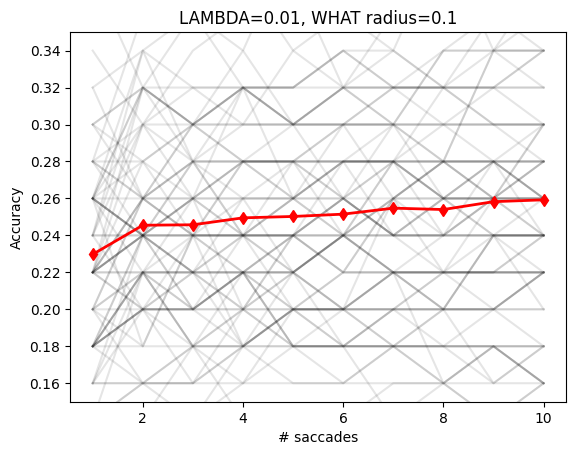

In [35]:
for test in range(80):
    plt.plot(range(1,11), mem_acc[test,:],'k', alpha=.1)
plt.plot(range(1,11), np.mean(mem_acc[:80,:], axis=0),'r', linewidth=2)
plt.plot(range(1,11), np.mean(mem_acc[:80,:], axis=0),'rd', linewidth=2)
plt.xlabel("# saccades")
plt.ylim((0.15,0.35))
plt.yticks([.16,.18,.20,.22,.24,.26,.28,.30,.32,.34])
plt.ylabel('Accuracy')
plt.title(f'LAMBDA={LAMBDA}, WHAT radius={args.radius}')

In [36]:
n_sample_train = None
n_sample_test = None

model.do_stn, model.do_what, model.deterministic, model.LAMBDA = do_stn, do_what, deterministic, LAMBDA

print(model.do_stn, model.do_what, model.deterministic)

training_step = 0

mem_acc = np.zeros((100,10))

args.radius = 0.1 
print(f'*** RADIUS : {args.radius} ***')

for test in range(100):

    data, label = next(iter(dataloader['test']))
    data_original, data_polo = data[0], data[1]
    data_original = data_original.to(device, dtype=torch.double)
    data_polo['in'] = data_polo['in'].to(device, dtype=torch.double)
    data_polo['out'] = data_polo['out'].to(device, dtype=torch.double)
    data_polo['ext'] = data_polo['ext'].to(device, dtype=torch.double)

    mem_output = []
    print('***', test, '***')
    for i in range(10):
        print(i, end=' ')
        if i == 0:
            model.do_what = False   
        else:
            model.do_what = True
        output = model(data_original, data_polo, training_step = training_step)
        if i ==0:
            max_output = output[0].detach().numpy()
        else:
            max_output = np.max((max_output,output[0].detach().numpy()), axis=0)
        mem_output  += [output[0].detach().numpy()]
        pred = max_output.argmax(axis=1)
        target = label.detach().numpy()
        #print(label, pred)
        print(np.equal(target, pred).mean())
        mem_acc[test,i] = np.equal(target, pred).mean()        
        
    print(mem_acc[test,:])



False True True
*** RADIUS : 0.1 ***
*** 0 ***
0 0.26
1 tensor([-0.1759,  0.0805])
0.18
2 tensor([0.0162, 0.1787])
0.22
3 tensor([0.0987, 0.1111])
0.2
4 tensor([-0.0209,  0.0187])
0.24
5 tensor([-0.0265,  0.0935])
0.24
6 tensor([-0.1256,  0.0833])
0.26
7 tensor([-0.1467, -0.1582])
0.3
8 tensor([0.0299, 0.1118])
0.3
9 tensor([ 0.0608, -0.0044])
0.3
[0.26 0.18 0.22 0.2  0.24 0.24 0.26 0.3  0.3  0.3 ]
*** 1 ***
0 0.26
1 tensor([-0.0067,  0.0431])
0.26
2 tensor([0.0788, 0.0427])
0.2
3 tensor([0.0802, 0.0096])
0.2
4 tensor([-0.1066,  0.0073])
0.24
5 tensor([-0.0700, -0.0076])
0.24
6 tensor([0.0699, 0.0956])
0.24
7 tensor([ 0.0613, -0.0876])
0.24
8 tensor([ 0.0377, -0.1333])
0.26
9 tensor([ 0.0264, -0.0815])
0.28
[0.26 0.26 0.2  0.2  0.24 0.24 0.24 0.24 0.26 0.28]
*** 2 ***
0 0.2
1 tensor([-0.1473,  0.1174])
0.24
2 tensor([ 0.1449, -0.0178])
0.22
3 tensor([-0.1060, -0.0113])
0.24
4 tensor([-0.0758, -0.0499])
0.26
5 tensor([ 0.0194, -0.0879])
0.26
6 tensor([0.0716, 0.1340])
0.26
7 tensor([-0.

Text(0.5, 1.0, 'LAMBDA=0.01, WHAT radius=0.1')

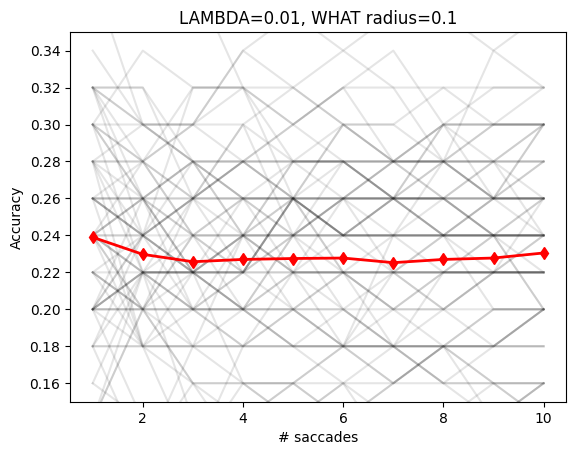

In [37]:
for test in range(77):
    plt.plot(range(1,11), mem_acc[test,:],'k', alpha=.1)
plt.plot(range(1,11), np.mean(mem_acc[:80,:], axis=0),'r', linewidth=2)
plt.plot(range(1,11), np.mean(mem_acc[:80,:], axis=0),'rd', linewidth=2)
plt.xlabel("# saccades")
plt.ylim((0.15,0.35))
plt.yticks([.16,.18,.20,.22,.24,.26,.28,.30,.32,.34])
plt.ylabel('Accuracy')
plt.title(f'LAMBDA={LAMBDA}, WHAT radius={args.radius}')

In [38]:
mem_center = []
mem_sac = []
for test in range(100):
    print(f'** {test} **')
    data, label = next(iter(dataloader['test']))
    data_original, data_polo = data[0], data[1]
    data_original = data_original.to(device, dtype=torch.double)
    data_polo['in'] = data_polo['in'].to(device, dtype=torch.double)
    data_polo['out'] = data_polo['out'].to(device, dtype=torch.double)
    data_polo['ext'] = data_polo['ext'].to(device, dtype=torch.double)
    
    mem_output = []
    for i in range(2):
        if i ==0:
            model.do_stn, model.do_what = False, True
            args.radius = 0
        else:       
            model.do_stn, model.do_what = True, False 
            args.radius = 0.1
        output = model(data_original, data_polo, training_step = training_step)
        if i ==0:
            sum_output = output[0]
        else:
            sum_output += output[0]
        mem_output  += [output[0]]
        pred_loc = output[0].argmax(dim=1, keepdim=True)
        pred = sum_output.argmax(dim=1, keepdim=True)
        print(pred_loc.eq(label.view_as(pred)).double().mean().item(),
              pred.eq(label.view_as(pred)).double().mean().item())
        if i ==0:
            mem_center +=[pred_loc.eq(label.view_as(pred)).double().mean().item()]
        else:
            mem_sac +=[pred_loc.eq(label.view_as(pred)).double().mean().item()]
        if False: #i > 0:
            theta = output[1]
            grid_size = torch.Size([data_original.size()[0], data_original.size()[1], 256, 256])
            grid = F.affine_grid(theta, grid_size).double()
            data_original = F.grid_sample(data_original, grid)
            data_polo ={'in': torch.zeros_like(data_polo['in']),
                               'out': torch.zeros_like(data_polo['out']),
                               'ext': torch.zeros_like(data_polo['ext'])}
            for i in range(args.batch_size):
                d, w = transform_in(data_original[i,...])
                data_polo['in'][i,...] = w['in']
                data_polo['out'][i,...] = w['out']
                data_polo['ext'][i,...] = w['ext']
    
    #pred = sum_output.argmax(dim=1, keepdim=True)
    #print(pred.eq(label.view_as(pred)).double().mean().item())


** 0 **
0.24 0.24
tensor([-0.0878, -0.0674], grad_fn=<SelectBackward0>)
0.22 0.28
** 1 **
0.28 0.28
tensor([0.0392, 0.0323], grad_fn=<SelectBackward0>)
0.32 0.3
** 2 **
0.2 0.2
tensor([0.0449, 0.0213], grad_fn=<SelectBackward0>)
0.24 0.2
** 3 **
0.26 0.26
tensor([ 0.0508, -0.0182], grad_fn=<SelectBackward0>)
0.3 0.32
** 4 **
0.28 0.28
tensor([0.0124, 0.0457], grad_fn=<SelectBackward0>)
0.2 0.24
** 5 **
0.22 0.22
tensor([-0.0183,  0.0758], grad_fn=<SelectBackward0>)
0.28 0.26
** 6 **
0.32 0.32
tensor([-0.1221,  0.0785], grad_fn=<SelectBackward0>)
0.32 0.32
** 7 **
0.18 0.18
tensor([ 0.0214, -0.0203], grad_fn=<SelectBackward0>)
0.18 0.16
** 8 **
0.24 0.24
tensor([ 0.0148, -0.0174], grad_fn=<SelectBackward0>)
0.24 0.26
** 9 **
0.2 0.2
tensor([ 0.0231, -0.0046], grad_fn=<SelectBackward0>)
0.1 0.16
** 10 **
0.2 0.2
tensor([0.0054, 0.0379], grad_fn=<SelectBackward0>)
0.16 0.18
** 11 **
0.22 0.22
tensor([-0.0002, -0.0137], grad_fn=<SelectBackward0>)
0.28 0.26
** 12 **
0.24 0.24
tensor([-0.060

In [39]:
np.mean(mem_center), np.mean(mem_sac)

(0.23199999999999998, 0.22960000000000005)

In [40]:
np.mean(mem_center), np.mean(mem_sac)

(0.23199999999999998, 0.22960000000000005)

In [41]:
radius

0.01

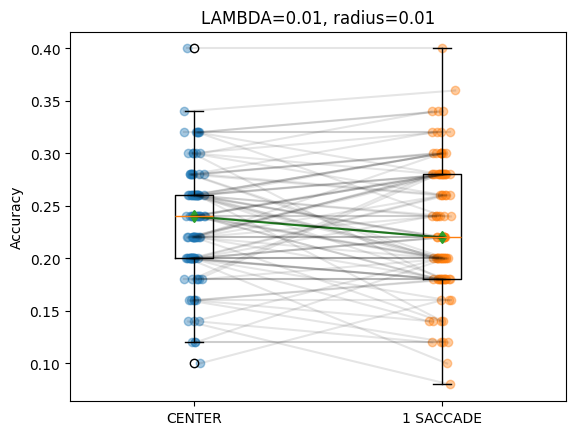

In [42]:
plt.boxplot([mem_center,mem_sac], labels = ['CENTER', '1 SACCADE']) #, showfliers=False)
plt.plot([1,2],(np.median(mem_center), np.median(mem_sac)),'d',color='tab:green')
plt.plot([1,2],(np.median(mem_center), np.median(mem_sac)),color='tab:green')

scat_1, scat_2 = np.random.randn(100)*0.02, np.random.randn(100)*0.02
plt.scatter(1+scat_1, mem_center, alpha=.4)
plt.scatter(2+scat_2, mem_sac, alpha=.4)
for i in range(100):
    plt.plot((1+scat_1[i], 2+scat_2[i]), (mem_center[i], mem_sac[i]), 'k', alpha=.1)
plt.title(f'LAMBDA={LAMBDA}, radius={radius}')
plt.ylabel('Accuracy')
plt.savefig(f'POLO-SAC-TEST-LAMB-{LAMBDA}-r-{radius}.png', bbox_inches='tight')


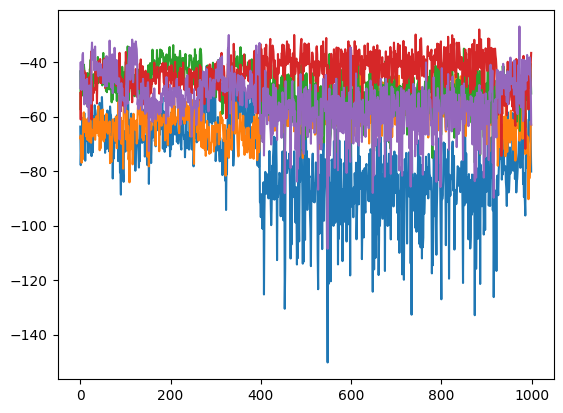

In [44]:
plt.plot(sum_output[:5,:].detach().numpy().T)

In [45]:
test_acc

NameError: name 'test_acc' is not defined

In [ ]:
data, label = next(iter(dataloader['train']))

In [ ]:
data_original, data_polo = data[0], data[1]
data_original = data_original.to(device, dtype=torch.double)
data_polo['in'] = data_polo['in'].to(device, dtype=torch.double)
data_polo['out'] = data_polo['out'].to(device, dtype=torch.double)
data_polo['ext'] = data_polo['ext'].to(device, dtype=torch.double)

In [ ]:
output = model(data_original, data_polo, training_step = 0)

In [ ]:
pred = output[0].argmax(dim=1, keepdim=True)
pred.eq(label.view_as(pred)).double().mean().item()

In [ ]:
cat = torch.argmax(F.softmax(output[0]),1)

In [ ]:
def img_denorm(img, mean, std):
    #for ImageNet the mean and std are:
    #mean = np.asarray([ 0.485, 0.456, 0.406 ])
    #std = np.asarray([ 0.229, 0.224, 0.225 ])

    denormalize = transforms.Normalize((-1 * mean / std), (1.0 / std))

    #res = img.squeeze(0)
    res = denormalize(img)

    #Image needs to be clipped since the denormalize function will map some
    #values below 0 and above 1
    res = torch.clamp(res, 0, 1)
    
    return(res)

In [ ]:
import json
fname = "imagenet-simple-labels.json"

with open(fname,'r') as f:
    class_labels = json.load(f)

In [ ]:
#theta = torch.cat((model.downscale.unsqueeze(0).repeat(
#            theta.size(0), 1, 1), theta.unsqueeze(2)),
#                          dim=2)
        
        #theta = theta.view(-1, 2, 3)
for num in range(50):
        plt.figure(figsize=(5,10))
        plt.subplot(1,2,1)
        img = data[0][num:num+1,...]   
        theta = output[1][num:num+1,...]
        #theta[0,:,2] = torch.FloatTensor((0,.5))
        print(theta[0,:,2].detach().numpy())
        grid_size = torch.Size([1, 3, 256, 256])
        grid = F.affine_grid(theta, grid_size)
        img_grid = F.grid_sample(img, grid.double())
        plt.imshow(img_denorm(data[0][num,...], v_mean, v_std).permute(1,2,0).detach().numpy())
        #plt.imshow(data[0][num,...].permute(1,2,0).detach().numpy())
        plt.plot(127.5, 127.5, 'r+')
        plt.title(class_labels[label[num]]+f' ({label[num]})')
        plt.subplot(1,2,2)
        plt.imshow(img_denorm(img_grid[0,:], v_mean, v_std).permute(1,2,0).detach().numpy())
        #plt.imshow(img_grid[0,:].permute(1,2,0).detach().numpy())
        plt.plot(127.5, 127.5, 'r+')
        plt.title(class_labels[cat[num]]+f' ({cat[num]})')

In [ ]:
data[0][num:num+1,...]

In [ ]:
data[0][num,...].shape